In [191]:
import numpy as np
import skimage
import seaborn as sns
from scipy.signal import convolve2d
from skimage.measure import label
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

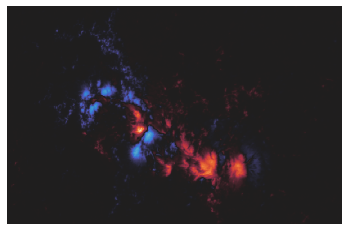

In [28]:
## load test data
data = np.load("test_data.npy")
image = data[0]
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True) # use the grayscale color map
sns.heatmap(image,center=0,cbar=False,xticklabels=False, yticklabels=False)

In [78]:
# I do not split image into pos/neg component this time, but will try to work directly on the image
# set up some physical threshold

PIL_maxGauss = 20 # the PIL candidate pixel cannot have vertical magnetic field component larger than 20 Gauss
PIL_max_gradi = 150 # the "strong" PIL candidate pixel cannot have a graident smaller than 150 Gauss
PIL_min_gradi = 50 # the PIL candidate pixel that has gradient lower than 50 cannot be considered as a PIL anymore

In [55]:
# In a discretized image, we cannot limit ourselves to pixels with low vertical components only. Since there can be some pixels
# with drastic magnetic field changes while at the same time being a high-Bz pixel. So the only criterion that we can rely on
# is that each pixel has locally a strong positive and a strong negative polar.

def local_polar_mask(image,threshold=100,hop=2):
    height = image.shape[0]
    width = image.shape[1]
    
    mask = np.zeros_like(image)
    pad_size = hop
    image_padded = np.pad(image,((pad_size,pad_size),(pad_size,pad_size)),'constant') # pad the image to make sure the output image has the same shape as the input image

    
    for i in range(height):
        for j in range(width):
            x = i+pad_size
            y = j+pad_size
            
            window = image_padded[(x-pad_size):(x+pad_size+1),(y-pad_size):(y+pad_size+1)] # the neighborhood subimage for each pixel
            maximum = np.amax(window) # find the local maximum
            minimum = np.amin(window) # find the local minimum
            if maximum>threshold and minimum<-(threshold): # retains the pixel value only if it has both a strong positive polar and a strong negative polar in its neighborhood subimage
                mask[i,j] = 1
    return mask

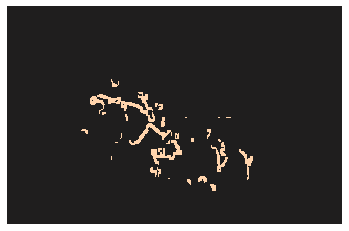

In [92]:
mask = local_polar_mask(image,threshold=100,hop=3)
sns.heatmap(mask,center=0,cbar=False,xticklabels=False, yticklabels=False)

In [69]:
# use non-maxima-suppression to thin the edges

def NMS(image,mask=None):
    gx = skimage.filters.prewitt_v(image) # positive if westwards
    gy = skimage.filters.prewitt_h(image) # positive if northwards
    
    phase = np.zeros_like(image)
    height = image.shape[0]
    width = image.shape[1]
    
    
    # coordinate explanation:
    #           pi/2
    #             ^
    #             ^
    #  0 <--- origin pixel ---> pi
    #             
    #         pi*(3/2)
    
    for i in range(height):
        for j in range(width):
            if gx[i,j]==0:
                continue
            if gx[i,j]>0 and gy[i,j]>0: # is Gx is pointing westwards, Gy is pointing northwards
                phase[i,j] = 180*np.arctan(gy[i,j]/gx[i,j])/np.pi
            elif gx[i,j]>0 and gy[i,j]<0: # is Gx is pointing westwards, Gy is pointing southwards
                phase[i,j] = 180*np.arctan(gy[i,j]/gx[i,j])/np.pi+360
            else:
                phase[i,j] = 180*np.arctan(gy[i,j]/gx[i,j])/np.pi+180
                
    # with the gradient direction calculated, we could do NMS
    edge_prewitt = skimage.filters.prewitt(image,mask=mask) # calculate the gradient of the image on specific pixels with local strong pos/neg
    edge_thin = np.zeros_like(edge_prewitt)
    
    if mask is not None:
        for i in range(height):
            for j in range(width):
                if mask[i,j]!=1 or gx[i,j]==0: # we should also add a check about whether [i,j] is a boundary pixel, but since mask typically ignores boundaries, we do not add the check here
                    continue
                if (phase[i][j] >= 337.5 or phase[i][j] < 22.5) or (phase[i][j] >= 157.5 and phase[i][j] < 202.5):
                    if (edge_prewitt[i,j]>edge_prewitt[i,j-1] and edge_prewitt[i,j]>edge_prewitt[i,j+1]):
                        edge_thin[i,j] = edge_prewitt[i,j]
                        
                if (phase[i][j] >= 22.5 and phase[i][j] < 67.5) or (phase[i][j] >= 202.5 and phase[i][j] < 247.5):
                    if (edge_prewitt[i,j]>edge_prewitt[i-1,j-1] and edge_prewitt[i,j]>edge_prewitt[i+1,j+1]):
                        edge_thin[i,j] = edge_prewitt[i,j]
                        
                if (phase[i][j] >= 67.5 and phase[i][j] < 112.5) or (phase[i][j] >= 247.5 and phase[i][j] < 292.5):
                    if (edge_prewitt[i,j]>edge_prewitt[i-1,j] and edge_prewitt[i,j]>edge_prewitt[i+1,j]):
                        edge_thin[i,j] = edge_prewitt[i,j]

                if (phase[i][j] >= 112.5 and phase[i][j] < 157.5) or (phase[i][j] >= 292.5 and phase[i][j] < 337.5):
                    if (edge_prewitt[i,j]>edge_prewitt[i-1,j+1] and edge_prewitt[i,j]>edge_prewitt[i+1,j-1]):
                        edge_thin[i,j] = edge_prewitt[i,j]
                        
        return edge_thin, phase
    

In [93]:
edge_thin, phase = NMS(image,mask=mask)

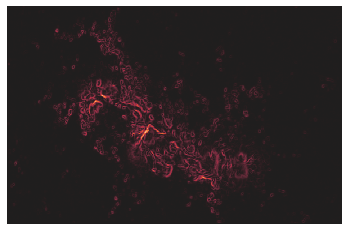

In [94]:
# use prewitt operator to calculate local gradients
prewitt_edge = skimage.filters.prewitt(image)
sns.heatmap(prewitt_edge,center=0,cbar=False,xticklabels=False, yticklabels=False)

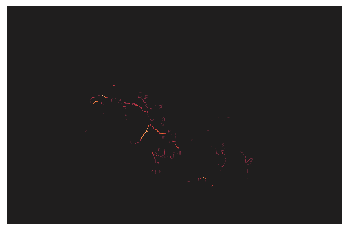

In [95]:
sns.heatmap(edge_thin,center=0,cbar=False,xticklabels=False, yticklabels=False)

In [96]:
binary_edge = edge_thin>0

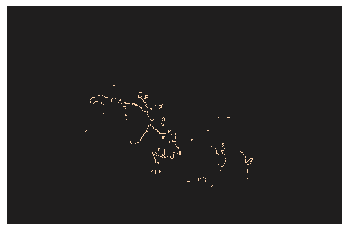

In [97]:
sns.heatmap(binary_edge,center=0,cbar=False,xticklabels=False, yticklabels=False)

In [79]:
hst_edge = skimage.filters.apply_hysteresis_threshold(edge_thin,PIL_min_gradi,PIL_max_gradi)

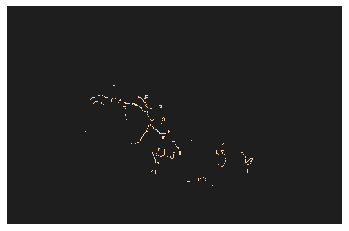

In [80]:
sns.heatmap(hst_edge,center=0,cbar=False,xticklabels=False, yticklabels=False)

In [169]:
# Now we are going to make PILs more connected:
def connect_PIL(edge_thin,phase,num_round=2):
    # this function aims at adding some PIL pixels to those isolated PIL points, such that PILs can be more connected
    binary_edge = edge_thin>0
    height = binary_edge.shape[0]
    width = binary_edge.shape[1]
    
    # step1: check if there is any isolated PIL points
    # iso_filter = np.array([[1,1,1],[1,0,1],[1,1,1]])
    
    # step2: let every edge point to vote for adjacent points along its gradient-perpendicular direction
    vote_form = np.zeros_like(binary_edge)
    for i in range(height):
        for j in range(width):
            if binary_edge[i,j]==0:
                continue
            
            if (phase[i][j] >= 337.5 or phase[i][j] < 22.5) or (phase[i][j] >= 157.5 and phase[i][j] < 202.5):
                vote_form[i-1,j] +=1
                vote_form[i+1,j] +=1
                        
            if (phase[i][j] >= 22.5 and phase[i][j] < 67.5) or (phase[i][j] >= 202.5 and phase[i][j] < 247.5):
                vote_form[i-1,j+1] +=1
                vote_form[i+1,j-1] +=1
                        
            if (phase[i][j] >= 67.5 and phase[i][j] < 112.5) or (phase[i][j] >= 247.5 and phase[i][j] < 292.5):
                vote_form[i,j-1] +=1
                vote_form[i,j+1] +=1

            if (phase[i][j] >= 112.5 and phase[i][j] < 157.5) or (phase[i][j] >= 292.5 and phase[i][j] < 337.5):
                vote_form[i-1,j-1] +=1
                vote_form[i+1,j+1] +=1
    
    for i in range(height):
        for j in range(width):
            if binary_edge[i,j]==0 and vote_form[i,j]>=1:
                binary_edge[i,j] = 1
                
    return binary_edge

In [170]:
new_edge = connect_PIL(edge_thin,phase)

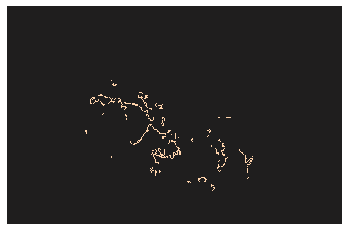

In [171]:
sns.heatmap(new_edge,center=0,cbar=False,xticklabels=False, yticklabels=False)

In [213]:
new_edge_thin = np.multiply(new_edge,prewitt_edge)

In [220]:
def denoise(edge_thin,eps=5,min_pts=5,PIL_minpts=100,gradi_min=150):
    binary_edge = edge_thin>0
    height = binary_edge.shape[0]
    width = binary_edge.shape[1]
    pixel_coor = []
    
    for i in range(height):
        for j in range(width):
            if binary_edge[i,j]==1:
                pixel_coor.append(np.array([i,j]))
    pixel_coor = np.array(pixel_coor)
    
    clust = DBSCAN(eps=eps,min_samples=min_pts,metric='manhattan')
    y = clust.fit_predict(X=pixel_coor)
    
    # y stores the cluster label for each of the pixel_coor
    # firstly, we take out all samples that belong to cluster of None (labeled as -1)
    #if (-1 in y):
    #    new_pixel_coor = []
    #    for i in range(len(y)):
    #        if y[i]!=-1:
    #            new_pixel_coor.append(pixel_coor[i])
    #    pixel_coor = new_pixel_coor
        
    #clust_sample = [np.sum(y==p) for p in np.unique(y)] # this counts the number of pixels in each of the cluster
    #delete_list = [num<PIL_minpts for num in clust_sample] # delete the clusters with too few points (or maybe too small gradients?)
    final_result = np.zeros_like(binary_edge)
    tmp = list(zip(pixel_coor,y))
    
    for lab in range(0,np.max(y)+1):
        clust_pts = [item[0] for item in tmp if item[1]==lab]
        clust_gradient = np.average([edge_thin[point[0],point[1]] for point in clust_pts])
        print(len(clust_pts),lab)
        
        if (len(clust_pts)>PIL_minpts and clust_gradient>gradi_min):
            for point in clust_pts:
                final_result[point[0],point[1]] = 1
                
    return final_result

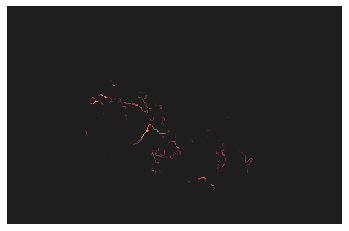

In [215]:
sns.heatmap(new_edge_thin,center=0,cbar=False,xticklabels=False, yticklabels=False)

28 0
536 1
121 2
42 3
14 4
31 5
52 6
10 7
294 8
27 9
21 10
420 11
6 12
27 13
247 14
177 15
9 16
63 17
21 18
71 19
20 20
40 21


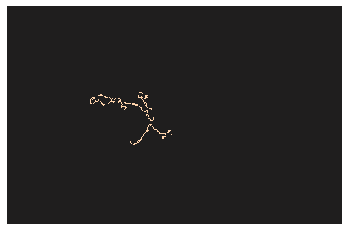

In [221]:
final_edge = denoise(new_edge_thin)
sns.heatmap(final_edge,center=0,cbar=False,xticklabels=False, yticklabels=False)

In [209]:
list(range(0,1))

[0]

In [178]:
label_image, num = label(new_edge,neighbors=8,background=0,return_num=True)
num

40

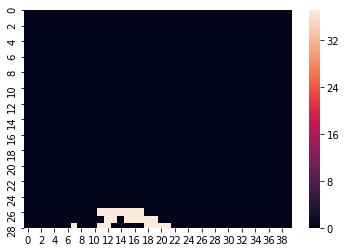

In [181]:
sns.heatmap(label_image[270:300,420:460])

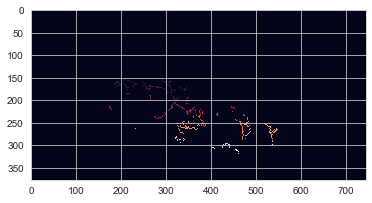

In [190]:
plt.imshow(label_image)

In [101]:
iso_filter = np.array([[1,1,1],[1,0,1],[1,1,1]])

In [124]:
binary_edge = binary_edge.astype(int)
iso = convolve2d(binary_edge,iso_filter,mode='same')
iso = np.logical_and(binary_edge,iso<1)

In [125]:
iso

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])